# CNN implementation from scratch

In this notebook we try to define and train a standard CNN from scratch, evaluating then the results on the test set

## Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

##Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

## Dataset splitting: train, test and validation

Constants:

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10
EPOCHS=15

The directories are moved and transformed in order to obtain the train and the test directories:

In [ ]:
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)

Found 3569 files belonging to 10 classes.
Using 3213 files for training.
Found 3569 files belonging to 10 classes.
Using 356 files for validation.
Found 402 files belonging to 10 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

##CNN definition

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
import pathlib

In [ ]:
class standardCNN:

    def __init__(self, train=None, test=None, val=None, classes=11, name='standardCNN'):
        # set datasets
        self.training_set = train
        self.val_set = val
        self.test_set = test
        self.name=name 
        
        # model
        inputs = ks.Input(shape=(224, 224, 3))
        x = layers.Rescaling(1. / 255)(inputs)
        x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

        # utils
        self.history = None

        self.dir_name ="/content/drive/Shareddrives/CIDL/project/models/CNN"
        if not os.path.exists(self.dir_name):
          os.makedirs(self.dir_name)
        self.save_path = os.path.join(self.dir_name, name+'.h5')

        self.callbacks_list = [
                  ks.callbacks.ModelCheckpoint(
                      filepath=self.save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True) #saves the best model in terms of the metric in monitor
                  ]

    def compile_and_fit(self, optimizer='adam', loss='categorical_crossentropy', learning_rate=None, epochs=EPOCHS):
        if learning_rate is not None:
            optimizer.learning_rate = learning_rate

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy']
        )

        self.history = self.model.fit(
             self.training_set,
             epochs=epochs,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )   

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, to_file=str(model_name) +".jpg", show_shapes=True)
    
    def train_more(self, epochs=EPOCHS):
      self.new_history = self.model.fit(
             self.training_set,
             epochs=epochs,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )
      for key in self.history.history.keys():
        self.history.history[key].extend(self.new_history.history[key])

    def load_best_model(self):
      self.model = ks.models.load_model(self.save_path)

    def save_history(self):
      with open(os.path.join(self.dir_name, self.name), 'wb') as file_pi:
        pickle.dump(self.history.history, file_pi)

    def load_history(self):
      with open(os.path.join(self.dir_name, self.name), 'rb') as file_pi:
        history = pickle.load(file_pi)
      return history  

    def evaluate(self, test=None):
      if test == None:
        test = self.test_set
      test_loss, test_acc = self.model.evaluate(self.test_set)
      print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

    def summary(self):
        self.model.summary()

In [ ]:
cnn_model = standardCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                         

##Model representation


In [ ]:
cnn_model.plot_model(model_name="standardCNN")

##Sanity check: overfit a bunch of data

If our network is not able to overfit a reduced amount of data, it will never be able to fit the training data

In [ ]:
training_images_reduced = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=0.8, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 3569 files belonging to 10 classes.
Using 714 files for training.


In [ ]:
cnn_model_to_overfit = standardCNN(train=training_images_reduced, val=val_images, test=test_images, classes=NUM_CLASSES)
cnn_model_to_overfit.compile_and_fit()

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 2.5260 - accuracy: 0.1877
Epoch 00001: val_loss improved from inf to 2.18354, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
6/6 [==============================] - 21s 1s/step - loss: 2.5260 - accuracy: 0.1877 - val_loss: 2.1835 - val_accuracy: 0.2725
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 2.0772 - accuracy: 0.2857
Epoch 00002: val_loss improved from 2.18354 to 2.04322, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
6/6 [==============================] - 8s 636ms/step - loss: 2.0772 - accuracy: 0.2857 - val_loss: 2.0432 - val_accuracy: 0.3146
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 1.8812 - accuracy: 0.3669
Epoch 00003: val_loss improved from 2.04322 to 1.83089, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
6/6 [==============================] - 7s 629ms/step - 

## Train network on the whole dataset

In [ ]:
cnn_model.compile_and_fit()

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 2.2186 - accuracy: 0.2353
Epoch 00001: val_loss improved from inf to 1.81923, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
26/26 [==============================] - 24s 683ms/step - loss: 2.2169 - accuracy: 0.2353 - val_loss: 1.8192 - val_accuracy: 0.3202
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.6493 - accuracy: 0.4231
Epoch 00002: val_loss improved from 1.81923 to 1.74621, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
26/26 [==============================] - 23s 669ms/step - loss: 1.6476 - accuracy: 0.4233 - val_loss: 1.7462 - val_accuracy: 0.3989
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.3923 - accuracy: 0.5119
Epoch 00003: val_loss improved from 1.74621 to 1.45642, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/standardCNN.h5
26/26 [==============================] - 

In [ ]:
cnn_model.save_history()

## Visualize results

In this section, we compare the results of the 3 tested classifier analyzing their behavior in terms of accuracy

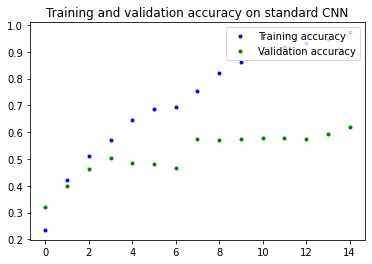

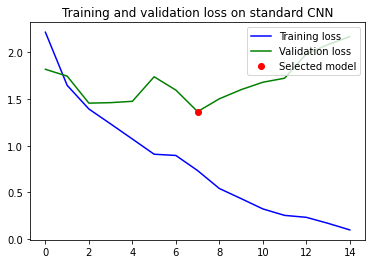

Lowest validation loss has been reached at epoch 7 with validation accuracy of 0.573


In [ ]:
history = standardCNN().load_history()
name='standard CNN'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
cnn_model.load_best_model()
cnn_model.evaluate(test_images)

4/4 [==============================] - 3s 77ms/step - loss: 0.6542 - accuracy: 0.7861
Test accuracy: 0.786, test loss: 0.654


## Considerations

The network reaches 57% of validation accuracy, but then overfits quickly. This could be caused mainly by 3 factors:


*   Lack of data
*   The spatial extent of the last feature map is still quite large, so the fully connected layer has a high number of parameters to train, about 50 times the available raw training images

*   Lack of regularization techniques





# Deeper network and dropout

Here we try to deepen the network, in order to reduce the dimensionality of the feature vector. The flattened vector is then passed to a fully connexted network that exploits Dropout.

## Model definition

In [ ]:
class DropoutCNN(standardCNN):
  def __init__(self, train=None, test=None, val=None, classes=11, name='DropoutCNN'):
    super().__init__(train, test, val, classes, name)
    
    inputs = ks.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
    self.model = ks.Model(inputs=inputs, outputs=outputs)


In [ ]:
dropout_model = DropoutCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
dropout_model.plot_model(model_name="DropoutCNN")
dropout_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                       

## Train network on the whole dataset

In [ ]:
dropout_model.compile_and_fit()

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 2.2144 - accuracy: 0.2016
Epoch 00001: val_loss improved from inf to 2.06726, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DropoutCNN.h5
26/26 [==============================] - 56s 2s/step - loss: 2.2132 - accuracy: 0.2017 - val_loss: 2.0673 - val_accuracy: 0.2612
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 2.0698 - accuracy: 0.2237
Epoch 00002: val_loss improved from 2.06726 to 1.90745, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DropoutCNN.h5
26/26 [==============================] - 24s 687ms/step - loss: 2.0708 - accuracy: 0.2232 - val_loss: 1.9074 - val_accuracy: 0.2978
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.9764 - accuracy: 0.2781
Epoch 00003: val_loss improved from 1.90745 to 1.82510, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DropoutCNN.h5
26/26 [==============================] - 24s 69

In [ ]:
dropout_model.train_more(epochs=5)

Epoch 1/5
25/26 [===========================>..] - ETA: 0s - loss: 0.5922 - accuracy: 0.7816
Epoch 00001: val_loss did not improve from 1.18463
26/26 [==============================] - 23s 651ms/step - loss: 0.5920 - accuracy: 0.7821 - val_loss: 1.3290 - val_accuracy: 0.6264
Epoch 2/5
25/26 [===========================>..] - ETA: 0s - loss: 0.5679 - accuracy: 0.7912
Epoch 00002: val_loss did not improve from 1.18463
26/26 [==============================] - 23s 660ms/step - loss: 0.5677 - accuracy: 0.7915 - val_loss: 1.3320 - val_accuracy: 0.5983
Epoch 3/5
25/26 [===========================>..] - ETA: 0s - loss: 0.6150 - accuracy: 0.7703
Epoch 00003: val_loss did not improve from 1.18463
26/26 [==============================] - 23s 645ms/step - loss: 0.6158 - accuracy: 0.7703 - val_loss: 1.4428 - val_accuracy: 0.5955
Epoch 4/5
25/26 [===========================>..] - ETA: 0s - loss: 0.6264 - accuracy: 0.7725
Epoch 00004: val_loss did not improve from 1.18463
26/26 [=====================

In [ ]:
dropout_model.save_history()

## Visualize results

In this section, we compare the results of the 3 tested classifier analyzing their behavior in terms of accuracy

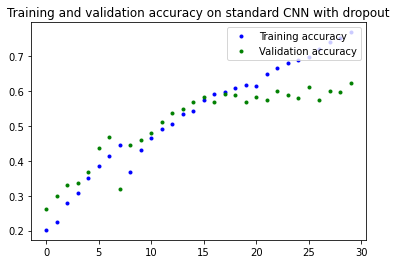

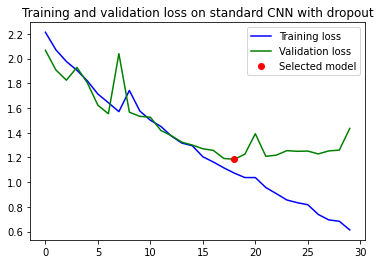

Lowest validation loss has been reached at epoch 18 with validation accuracy of 0.590


In [ ]:
history = DropoutCNN().load_history()
name='standard CNN with dropout'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
dropout_model.load_best_model()
dropout_model.evaluate(test_images)

4/4 [==============================] - 5s 103ms/step - loss: 1.1516 - accuracy: 0.6244
Test accuracy: 0.624, test loss: 1.152


##Considerations

The regularization given by the dropout enhanced the validation accuracy, however the reduction of parameters made the network struggling in learning from the training set, especially at the beginning

# Bigger network and early stopping

In this block we try to increase the network size, in order to verify if it is possible to increase validation accuracy. We also equip the network with an early stopping mechanism, in order to block training if no improvement is detected

## Model definition

In [ ]:
class BiggerCNN(standardCNN):
  def __init__(self, train=None, test=None, val=None, classes=11, name='BiggerCNN'):
    super().__init__(train, test, val, classes, name)
    inputs = ks.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
    self.model = ks.Model(inputs=inputs, outputs=outputs)

    self.callbacks_list.append(ks.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))


In [ ]:
bigger_model = BiggerCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
bigger_model.plot_model(model_name="BiggerCNN")
bigger_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                      

## Train network on the whole dataset

In [ ]:
bigger_model.compile_and_fit(epochs = 100)

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.1282 - accuracy: 0.2294
Epoch 00001: val_loss improved from inf to 1.98784, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerCNN.h5
26/26 [==============================] - 28s 659ms/step - loss: 2.1282 - accuracy: 0.2294 - val_loss: 1.9878 - val_accuracy: 0.3258
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 1.8955 - accuracy: 0.3375
Epoch 00002: val_loss improved from 1.98784 to 1.76980, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerCNN.h5
26/26 [==============================] - 23s 655ms/step - loss: 1.8929 - accuracy: 0.3386 - val_loss: 1.7698 - val_accuracy: 0.3708
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 1.7375 - accuracy: 0.3944
Epoch 00003: val_loss improved from 1.76980 to 1.70450, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BiggerCNN.h5
26/26 [==============================] - 24s

In [ ]:
bigger_model.save_history()

## Visualize results

In this section, we compare the results of the 3 tested classifier analyzing their behavior in terms of accuracy

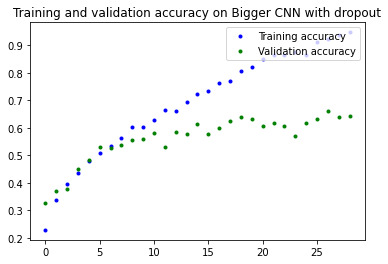

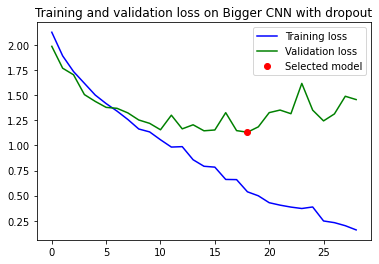

Lowest validation loss has been reached at epoch 18 with validation accuracy of 0.638


In [ ]:
history = BiggerCNN().load_history()
name='Bigger CNN with dropout'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
bigger_model.load_best_model()
bigger_model.evaluate(test_images)

4/4 [==============================] - 3s 92ms/step - loss: 1.1742 - accuracy: 0.6443
Test accuracy: 0.644, test loss: 1.174


## Considerations

Combining the benefit of dropout and of improved capacity, the network is capable to perform better both on test and on validation set 

# CNN with Batch Normalization

Batch is a techniques that, through the normalization (subtract mean, divide std dev) of each input belonging to a batch, aims at improving the stability of the network itself. Batch normalization layer is tipically applied before each non-linearity. 

## Model definition

In [ ]:
class BatchNormalizationCNN(BiggerCNN):
  def __init__(self, train=None, test=None, val=None, classes=11, name='BatchNormalizationCNN'):
    super().__init__(train, test, val, classes, name)
    inputs = ks.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1. / 255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)
    x = layers.BatchNormalization(epsilon = 1e-4)(x)
    x = layers.Activation(('relu'))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    x = layers.BatchNormalization(epsilon = 1e-4)(x)
    x = layers.Activation(('relu'))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(x)
    x = layers.BatchNormalization(epsilon = 1e-4)(x)
    x = layers.Activation(('relu'))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(x)
    x = layers.BatchNormalization(epsilon = 1e-4)(x)
    x = layers.Activation(('relu'))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
    self.model = ks.Model(inputs=inputs, outputs=outputs)


In [ ]:
batch_normalization_model = BatchNormalizationCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
batch_normalization_model.plot_model(model_name="BatchNormalizationCNN")
batch_normalization_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                     

## Train network on the whole dataset

In [ ]:
batch_normalization_model.compile_and_fit(epochs = 100)

Epoch 1/100
25/26 [===========================>..] - ETA: 0s - loss: 2.3980 - accuracy: 0.2344
Epoch 00001: val_loss improved from inf to 2.28980, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BatchNormalizationCNN2.h5
26/26 [==============================] - 26s 740ms/step - loss: 2.3964 - accuracy: 0.2340 - val_loss: 2.2898 - val_accuracy: 0.1573
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 1.8859 - accuracy: 0.3447
Epoch 00002: val_loss improved from 2.28980 to 2.26286, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/BatchNormalizationCNN2.h5
26/26 [==============================] - 24s 715ms/step - loss: 1.8858 - accuracy: 0.3448 - val_loss: 2.2629 - val_accuracy: 0.1545
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 1.7408 - accuracy: 0.4006
Epoch 00003: val_loss did not improve from 2.26286
26/26 [==============================] - 24s 693ms/step - loss: 1.7418 - accuracy: 0.4002 - val_loss: 2.

In [ ]:
batch_normalization_model.save_history()

## Visualize results

In this section, we compare the results of the 3 tested classifier analyzing their behavior in terms of accuracy

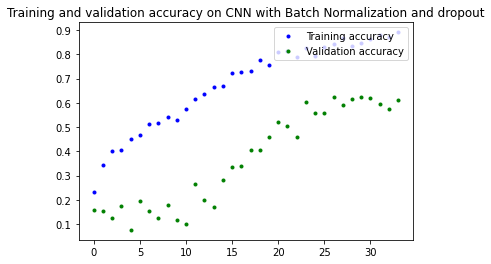

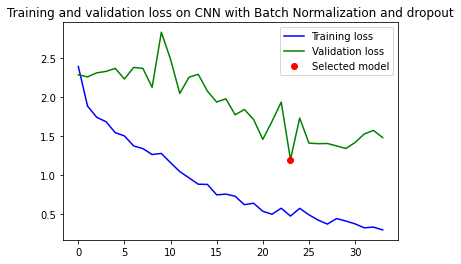

Lowest validation loss has been reached at epoch 23 with validation accuracy of 0.604


In [ ]:
history = BatchNormalizationCNN().load_history()
name='CNN with Batch Normalization and dropout'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
batch_normalization_model.load_best_model()
batch_normalization_model.evaluate(test_images)

4/4 [==============================] - 3s 143ms/step - loss: 1.2942 - accuracy: 0.6144
Test accuracy: 0.614, test loss: 1.294


## Considerations

As results show, batch normalization is not very suitable for our task and especially for the reduced size of our network and dataset: the test and validation accuracy did not improve, but on the contrary the training process is noisier.

# CNN with Data Augmentation

The aim of data augmentation is to avoid overfitting by generating training images to which we apply small modifications, like random rotations, flipping or scale. In the following, we try to add a Data Augmentation Layer to see if it improves the prediction accuracy of the network

## Model definition

In [ ]:
data_augmentation = ks.Sequential(
  [
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.2) #, 
    #layers.RandomTranslation(height_factor=(-0.1, 0,1), width_factor=(-0.1, 0.1))
  ]
)

In [ ]:
class DataAugmentedCNN(BiggerCNN):
  def __init__(self, train=None, test=None, val=None, classes=11, name='DataAugmentedCNN'):
    super().__init__(train, test, val, classes, name)
    inputs = ks.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1. / 255)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=4)(x)
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
    self.model = ks.Model(inputs=inputs, outputs=outputs)


In [ ]:
data_augmented_model = DataAugmentedCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
data_augmented_model.plot_model(model_name="DataAugmentedCNN")
data_augmented_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 56, 56, 128)       73856     
                                                          

## Train network on the whole dataset

In [ ]:
data_augmented_model.compile_and_fit(epochs = 100)

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.2054 - accuracy: 0.1951
Epoch 00001: val_loss improved from inf to 2.06587, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DataAugmentedCNN.h5
26/26 [==============================] - 30s 841ms/step - loss: 2.2054 - accuracy: 0.1951 - val_loss: 2.0659 - val_accuracy: 0.2472
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 2.0198 - accuracy: 0.2571
Epoch 00002: val_loss improved from 2.06587 to 1.83471, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/DataAugmentedCNN.h5
26/26 [==============================] - 28s 859ms/step - loss: 2.0198 - accuracy: 0.2571 - val_loss: 1.8347 - val_accuracy: 0.3062
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 1.8491 - accuracy: 0.3243
Epoch 00003: val_loss did not improve from 1.83471
26/26 [==============================] - 25s 739ms/step - loss: 1.8491 - accuracy: 0.3243 - val_loss: 1.8900 - val_a

In [ ]:
data_augmented_model.train_more(epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.6643 - accuracy: 0.4227
Epoch 00001: val_loss did not improve from 1.82725
26/26 [==============================] - 44s 1s/step - loss: 1.6643 - accuracy: 0.4227 - val_loss: 2.1823 - val_accuracy: 0.3090
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 1.6169 - accuracy: 0.4192
Epoch 00002: val_loss did not improve from 1.82725
26/26 [==============================] - 25s 743ms/step - loss: 1.6169 - accuracy: 0.4192 - val_loss: 3.0056 - val_accuracy: 0.2837
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 1.6519 - accuracy: 0.4068
Epoch 00003: val_loss did not improve from 1.82725
26/26 [==============================] - 25s 749ms/step - loss: 1.6519 - accuracy: 0.4068 - val_loss: 2.0683 - val_accuracy: 0.3118
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 1.5011 - accuracy: 0.4575
Epoch 00004: val_loss did not improve from 1.82725
26/26 [====================

In [ ]:
data_augmented_model.save_history()

## Visualize results

In this section, we see the results of the tested classifier analyzing its behavior in terms of accuracy

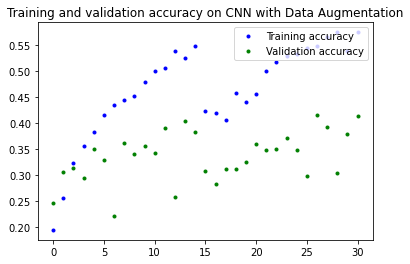

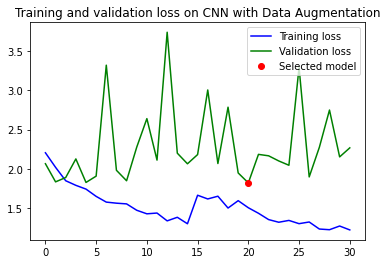

Lowest validation loss has been reached at epoch 20 with validation accuracy of 0.360


In [ ]:
history = DataAugmentedCNN().load_history()
name='CNN with Data Augmentation'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
data_augmented_model.load_best_model()
data_augmented_model.evaluate(test_images)

4/4 [==============================] - 3s 248ms/step - loss: 1.7557 - accuracy: 0.4055
Test accuracy: 0.405, test loss: 1.756


## Considerations

With data augmentation the model underfits. The only solution would be to increase model size, however due to Colab limitations we cannot try to train it.